<a href="https://colab.research.google.com/github/Bmartins25/Inter_Analista_Dados_Pyspark/blob/main/Teste_Bruno_Inter_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=d66ef7f766146f2646ad55356220a1e176970b4ef746956d365d89bb361682f2
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [3]:
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [4]:
file_path = "/content/Base_Case_Marketplace.xlsx"
df_pandas = pd.read_excel(file_path, sheet_name='TesteInter')

In [5]:
# Iniciando uma sessão do Spark
spark = SparkSession.builder.appName("MarketplaceAnalysis").getOrCreate()

In [6]:

df_spark = spark.createDataFrame(df_pandas)

In [7]:
df_spark.show()

+--------+---------+--------+---------+-------+--------+-------------------+--------------+---+
|CASHBACK|VL_COMPRA|ID_CONTA| ID_VENDA|ID_LOJA|DS_MOEDA|          DT_COMPRA|        CIDADE| UF|
+--------+---------+--------+---------+-------+--------+-------------------+--------------+---+
|   13.47|    96.86|20146749|600787864|  43930|     BRL|2020-11-06 13:08:34|BELO HORIZONTE| MG|
|   10.63|    25.72|20146749|602439767|  43930|     BRL|2020-11-10 21:37:16|BELO HORIZONTE| MG|
|   13.47|    96.86|20146749|599831099|  43930|     BRL|2020-11-03 21:54:17|BELO HORIZONTE| MG|
|    23.6|   179.99|20041626| 1f03d2cc|  12345|     BRL|2020-11-18 23:20:33|   CACIMBINHAS| AL|
|   31.52|    279.0|20228100| 5d9b38d4|  12345|     BRL|2020-11-19 14:13:17|        MANAUS| AM|
|   11.74|     44.9|20228100| 95a3c89a|  12345|     BRL|2020-11-21 00:30:22|        MANAUS| AM|
|   10.46|    19.18|20136111| 169552af|  12345|     BRL|2020-09-23 11:22:03|        MANAUS| AM|
|   11.67|     33.9|20136111| 12e6a26a| 

1. Lojas que nossos clientes mais compram:
+-------+-------------+
|ID_LOJA|total_compras|
+-------+-------------+
|  12345|       115539|
|  54321|        27679|
|  21345|        25192|
|  37758|        16473|
|  12230|        12578|
|  35258|        12138|
|  35344|        10618|
|  35638|        10425|
|  24156|         6809|
|  32145|         6572|
|  35684|         4407|
|  35612|         4384|
|  43215|         3780|
|  35394|         3739|
|  35614|         2842|
|  35330|         2599|
|  21540|         2566|
|  35304|         2545|
|  38082|         2487|
|  24780|         2264|
+-------+-------------+
only showing top 20 rows


2. Tendência de compras ao longo do tempo:
+----+---+-------------+
| ano|mes|total_compras|
+----+---+-------------+
|2020|  7|        15440|
|2020|  8|        50673|
|2020|  9|        51461|
|2020| 10|        95875|
|2020| 11|        94227|
+----+---+-------------+


3. Aumento nas vendas ao longo do tempo:
+----+---+-------------+
| ano|mes|total_co

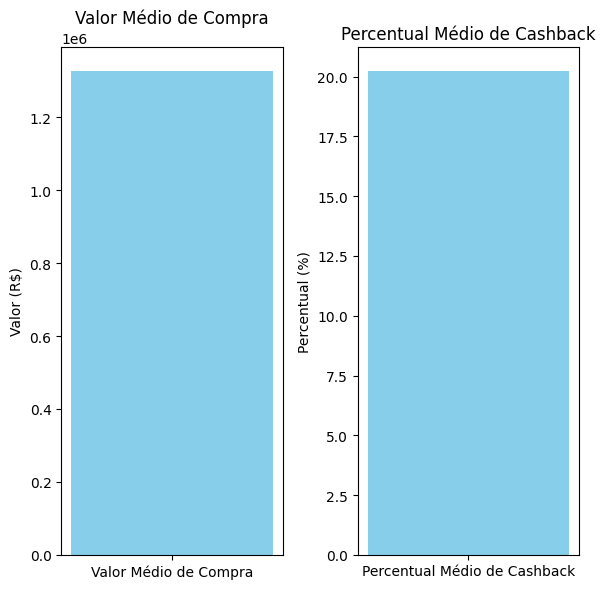

In [19]:
from pyspark.sql import functions as F

# 1. Quais são as lojas que nossos clientes mais compram?
lojas_populares = df_spark.groupBy("ID_LOJA").agg(F.count("ID_VENDA").alias("total_compras")).orderBy(F.col("total_compras").desc())

# Exibindo o resultado das lojas mais populares
print("1. Lojas que nossos clientes mais compram:")
lojas_populares.show()

# 2. Existe algum padrão ou tendência relevante nas compras de nossos clientes?
# Extraindo ano e mês da coluna de data
df_spark = df_spark.withColumn("ano", F.year("DT_COMPRA")).withColumn("mes", F.month("DT_COMPRA"))

tendencia_compras = df_spark.groupBy("ano", "mes").agg(F.count("ID_VENDA").alias("total_compras")).orderBy("ano", "mes")

# Exibindo a tendência de compras ao longo do tempo
print("\n2. Tendência de compras ao longo do tempo:")
tendencia_compras.show()

# 3. Existe um aumento nas vendas ao longo do tempo?
# Para verificar o aumento nas vendas, vamos ordenar pelo total de compras
aumento_vendas = tendencia_compras.orderBy(F.col("total_compras").desc())

# Exibindo o aumento nas vendas
print("\n3. Aumento nas vendas ao longo do tempo:")
aumento_vendas.show()

# 4. Qual é o valor médio de compras dos nossos clientes?
valor_medio_compras = df_spark.agg(F.avg("VL_COMPRA").alias("valor_medio_compra"))

# Exibindo o valor médio das compras
print("\n4. Valor médio de compras dos clientes:")
valor_medio_compras.show()

# 5. Qual é o percentual médio de cashback que nossos clientes recebem?
df_spark = df_spark.withColumn("percentual_cashback", (F.col("CASHBACK") / F.col("VL_COMPRA")) * 100)
percentual_cashback_medio = df_spark.agg(F.avg("percentual_cashback").alias("media_percentual_cashback"))
percentual_cashback_medio_pd = percentual_cashback_medio.toPandas()

# Exibindo o percentual médio de cashback recebido pelos clientes
print("\n5. Percentual médio de cashback recebido pelos clientes:")
percentual_cashback_medio.show()


# Gráfico de barras para valor médio de compras e cashback
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

# Valor médio de compras
ax[0].bar(['Valor Médio de Compra'], valor_medio_compras_pd['valor_medio_compra'], color='skyblue')
ax[0].set_title('Valor Médio de Compra')
ax[0].set_ylabel('Valor (R$)')

# Percentual médio de cashback
ax[1].bar(['Percentual Médio de Cashback'], percentual_cashback_medio_pd['media_percentual_cashback'], color='skyblue')
ax[1].set_title('Percentual Médio de Cashback')
ax[1].set_ylabel('Percentual (%)')

plt.tight_layout()
plt.show()
